# Optimal Transport for single-cell omics

This Jupyter Notebook will walk you trough the code to replicate the experiments from our research on applying OT as a loss function in between single-cell omics data. [Bioinformatics paper](https://academic.oup.com/bioinformatics/article/38/8/2169/6528312).

The code is designed to be run on GPU. If you do not have access to a GPU you may want to use a free Google Colab instance to run this notebook.

## Imports

Uncomment this if running on Google Colab

In [94]:
# !git clone https://github.com/ComputationalSystemsBiology/OT-scOmics.git
#!pip install scanpy
#!pip install leidenalg
#!pip install otscomics

General libraries to load data, do computations and make plots.

In [95]:

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

Function to compute pairwise distance matrices for various functions (e.g. euclidean, cosine ...).

In [96]:
from scipy.spatial.distance import cdist

Clustering models used for evaluation.

In [97]:
from sklearn.cluster import AgglomerativeClustering, SpectralClustering

Metrics used for scoring.

In [98]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import normalized_mutual_info_score

Library `tqdm` makes pretty progress bars.

In [99]:
from tqdm import tqdm

Our library to compute the OT distance matrix.

In [100]:
import otscomics

Scanpy and AnnData container.

In [101]:
import scanpy as sc
import anndata as ad

In [102]:
import pandas as pd
import numpy as np
%cd /home/onyxia/work
!pwd

/home/onyxia/work
/home/onyxia/work


## Load preprocessed data

We provide preprocessed data as compressed csv files, with features as rows and cell as columns. The target classes (cell type or cell line) are given in the column name.

In [103]:
# Load the data.
data = pd.read_csv('OT-scOmics/data/liu_scrna_preprocessed.csv.gz', index_col=0)

In [104]:
data.shape

(10994, 206)

In [105]:
# Retrieve the clusters.
clusters = np.array([col.split('_')[-1] for col in data.columns])
idx = np.argsort(clusters) # Sorted indices (for visulization)

In [106]:
clusters.shape

(206,)

In [107]:
# Display unique clusters.
np.unique(clusters)

array(['HCT', 'Hela', 'K562'], dtype='<U4')

In [108]:
data = data.iloc[np.argsort(data.std(1))[::-1][:1_000]]

Converting the dataset to an AnnData for the rest of the analysis.

In [109]:
adata = ad.AnnData(data.T)
adata.obs['cell_line'] = clusters

## Compute distance matrix

In this section we will compute distance matrices between cells using both Optimal Transport and the Euclidean distance.

### Compute baseline distance matrix

Let us start by computing the euclidean distance matrix. You may change the following line of code using `cityblock`, `cosine`, `correlation` or any Scipy-compatible distance.

In [110]:
# Replace `euclidean` with any scipy distance metric.
D_eu = cdist(adata.X, adata.X, metric='euclidean')
D_eu /= D_eu.max()

Displaying the distance matrix, with cells ordered by class. Clusters should be visible in the form of diagonal blocks of close distances.

In [111]:
pd.DataFrame(D_eu)

0         1         2         3         4         5         6    \
0    0.000000  0.437618  0.412298  0.491545  0.379292  0.405086  0.407510   
1    0.437618  0.000000  0.394179  0.491449  0.360924  0.405894  0.405934   
2    0.412298  0.394179  0.000000  0.492744  0.336936  0.397985  0.413082   
3    0.491545  0.491449  0.492744  0.000000  0.465616  0.481924  0.489198   
4    0.379292  0.360924  0.336936  0.465616  0.000000  0.339342  0.358772   
..        ...       ...       ...       ...       ...       ...       ...   
201  0.862585  0.844001  0.874128  0.821591  0.852921  0.878920  0.872798   
202  0.802514  0.765579  0.804316  0.759032  0.777139  0.806053  0.798974   
203  0.809481  0.790433  0.818225  0.779652  0.789044  0.822019  0.812847   
204  0.789599  0.753465  0.772897  0.776688  0.758532  0.793520  0.783874   
205  0.832040  0.809613  0.832883  0.795306  0.819676  0.856758  0.837345   

          7         8         9    ...       196       197       198  \
0    0.381387  0.424441  0.426572  ...  0.795955  0.846049  0.847497   
1    0.366637  0.416169  0.423209  ...  0.772067  0.828852  0.824316   
2    0.345026  0.410432  0.410681  ...  0.803020  0.862162  0.854958   
3    0.483923  0.483962  0.488689  ...  0.766748  0.798821  0.808574   
4    0.293923  0.367719  0.366606  ...  0.774407  0.839097  0.832190   
..        ...       ...       ...  ...       ...       ...       ...   
201  0.878880  0.861202  0.872135  ...  0.485445  0.467679  0.459032   
202  0.802498  0.795723  0.795496  ...  0.476374  0.495110  0.477336   
203  0.809082  0.817951  0.812884  ...  0.438596  0.446265  0.488018   
204  0.778769  0.780974  0.782987  ...  0.464181  0.496588  0.509063   
205  0.846210  0.823994  0.839509  ...  0.458152  0.480700  0.482024   

          199       200       201       202       203       204       205  
0    0.863082  0.797433  0.862585  0.802514  0.809481  0.789599  0.832040  
1    0.854012  0.775400  0.844001  0.765579  0.790433  0.753465  0.809613  
2    0.881516  0.797485  0.874128  0.804316  0.818225  0.772897  0.832883  
3    0.810576  0.767058  0.821591  0.759032  0.779652  0.776688  0.795306  
4    0.869060  0.772683  0.852921  0.777139  0.789044  0.758532  0.819676  
..        ...       ...       ...       ...       ...       ...       ...  
201  0.442246  0.458744  0.000000  0.493786  0.485656  0.509667  0.484301  
202  0.467974  0.436454  0.493786  0.000000  0.488487  0.479312  0.491217  
203  0.499166  0.414016  0.485656  0.488487  0.000000  0.476952  0.479818  
204  0.527470  0.437331  0.509667  0.479312  0.476952  0.000000  0.472444  
205  0.467065  0.443267  0.484301  0.491217  0.479818  0.472444  0.000000  

[206 rows x 206 columns]

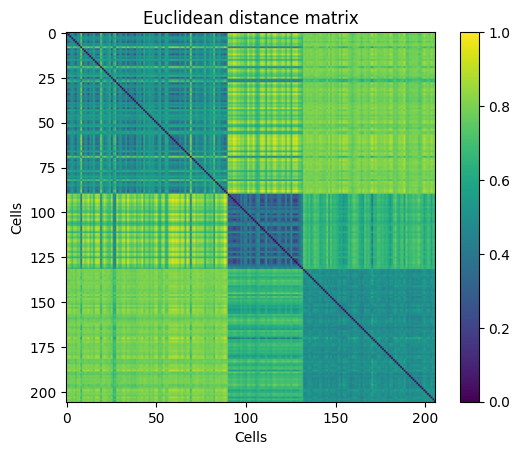

In [112]:
plt.imshow(D_eu[idx][:,idx])
plt.title('Euclidean distance matrix')
plt.xlabel('Cells')
plt.ylabel('Cells')
plt.colorbar()
plt.show()

### Compute OT distance matrix

Now on the OT distance matrix. We first need to normalize cells (divide columns by their sum). This is because Optimal Transport works on probability distributions. We then compute a cost matrix (you may change `cosine` by another function) and the associated OT distance matrix.

In [113]:
# Per-cell normalization (mandatory)
data_norm = adata.X.T.astype(np.double)
data_norm /= data_norm.sum(0)
# Add a small value to avoid numerical errors
data_norm += 1e-9
data_norm /= data_norm.sum(0)

In [114]:
# Compute OT distance matrix
C = otscomics.cost_matrix(adata.X.T.astype(np.double), 'cosine')
D_ot, errors = otscomics.OT_distance_matrix(
    data=data_norm, cost=C, eps=.1,
    dtype=torch.double, device='cuda'
)

In [115]:
print("Shape:", D_ot.shape)
print("Dtype:", D_ot.dtype)
print("Any NaN:", np.isnan(D_ot).any())
print("Any Inf:", np.isinf(D_ot).any())
print("Min value:", D_ot.min())


Shape: (206, 206)
Dtype: float64
Any NaN: False
Any Inf: False
Min value: 0.0


In [116]:
neg_positions = np.where(D_ot < 0)
list(zip(neg_positions[0], neg_positions[1]))

[]

Displaying the OT distance matrix, with cells ordered by class. Clusters should be visible in the form of diagonal blocks of low distances.

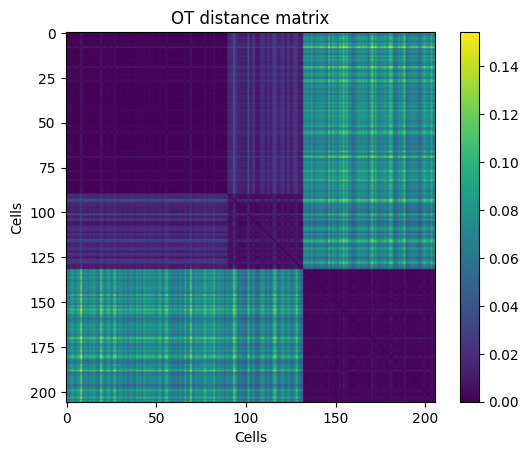

In [117]:
plt.imshow(D_ot[idx][:,idx])
plt.title('OT distance matrix')
plt.xlabel('Cells')
plt.ylabel('Cells')
plt.colorbar()
plt.show()

## Scoring

Let us compare the score for both distance matrices.

### Silhouette score

In [118]:
print('Euclidean\t',  silhouette_score(D_eu, clusters, metric='precomputed'))
print('OT\t\t',       silhouette_score(D_ot, clusters, metric='precomputed'))

Euclidean	 0.310142677550168
OT		 0.8380411531906459


### C index

In [119]:
print('Euclidean\t',  otscomics.C_index(D_eu, clusters))
print('OT\t\t',       otscomics.C_index(D_ot, clusters))


Euclidean	 0.034578119156775076
OT		 0.0023526581284776913


### Hierarchical clustering (fixed number of clusters)

We first cluster cells based on hierarchical clustering, fixed the number of clusters to the number of classes in the ground truth.

In [120]:
cl = AgglomerativeClustering(metric='precomputed', n_clusters=len(np.unique(clusters)), linkage='complete')

In [121]:
print('Euclidean')
cl.set_params().fit(D_eu)
print('ARI', adjusted_rand_score(clusters, cl.labels_))
print('NMI', normalized_mutual_info_score(clusters, cl.labels_))
print('AMI', adjusted_mutual_info_score(clusters, cl.labels_))

Euclidean
ARI 0.9215689106896331
NMI 0.9084054726687504
AMI 0.9075477330695366


In [122]:
print('OT')
cl.set_params().fit(D_ot)
print('ARI', adjusted_rand_score(clusters, cl.labels_))
print('NMI', normalized_mutual_info_score(clusters, cl.labels_))
print('AMI', adjusted_mutual_info_score(clusters, cl.labels_))

OT
ARI 1.0
NMI 1.0
AMI 1.0


### Hiarchical clustering (number of clusters derived from silhouette)

A more realistic setting is to find the "optimal" number of clusters in an unsupervised way. We run the clustering for every number of clusters between 3 and 25, and select the clustering yielding the best silhouette score.

In [123]:
cl = AgglomerativeClustering(metric='precomputed', linkage='complete')

range_clusters, sil = range(3, 26), []

# Iterate through numbers of clusters
for n_clusters in range_clusters:
  cl.set_params(n_clusters=n_clusters).fit(D_eu)
  sil.append(silhouette_score(D_eu, cl.labels_, metric='precomputed'))

# Select the number yielding best silhouette
cl.set_params(n_clusters=range_clusters[np.argmax(sil)]).fit(D_eu)

print('Euclidean,', range_clusters[np.argmax(sil)], 'clusters')
print('ARI', adjusted_rand_score(clusters, cl.labels_))
print('NMI', normalized_mutual_info_score(clusters, cl.labels_))
print('AMI', adjusted_mutual_info_score(clusters, cl.labels_))

Euclidean, 3 clusters
ARI 0.9215689106896331
NMI 0.9084054726687504
AMI 0.9075477330695366


In [124]:
cl = AgglomerativeClustering(metric='precomputed', linkage='complete')

range_clusters, sil = range(3, 26), []

# Iterate through numbers of clusters
for n_clusters in range_clusters:
  cl.set_params(n_clusters=n_clusters).fit(D_ot)
  sil.append(silhouette_score(D_ot, cl.labels_, metric='precomputed'))

# Select the number yielding best silhouette
cl.set_params(n_clusters=range_clusters[np.argmax(sil)]).fit(D_ot)

print('OT,', range_clusters[np.argmax(sil)], 'clusters')
print('ARI', adjusted_rand_score(clusters, cl.labels_))
print('NMI', normalized_mutual_info_score(clusters, cl.labels_))
print('AMI', adjusted_mutual_info_score(clusters, cl.labels_))

OT, 3 clusters
ARI 1.0
NMI 1.0
AMI 1.0


### A typical single-cell clustering based on Leiden

In practice, single-cell clustering is often done by computing a kNN network according to euclidean distance on PCA components, and then performing Leiden clustering on that network. Here, we compare this typical workflow with Leiden clustering on the kNN network computed directly from the OT distance matrix.

In [125]:
print('PCA + euclidean + kNN + Leiden')

sc.pp.pca(adata)
sc.pp.neighbors(adata)

resolutions = np.linspace(.25, 1.5, 20)
sils, aris, nmis, amis, n_clusters = [], [], [], [], []

# Iterate through resolutions
print('Iterating through resolutions...')
for resolution in tqdm(resolutions):
  
  sc.tl.leiden(adata, resolution=resolution)

  if len(np.unique(adata.obs['leiden'])) > 1:
    sils.append(silhouette_score(D_ot, adata.obs['leiden'], metric='precomputed'))
    aris.append(adjusted_rand_score(clusters, adata.obs['leiden']))
    nmis.append(normalized_mutual_info_score(clusters, adata.obs['leiden']))
    amis.append(adjusted_mutual_info_score(clusters, adata.obs['leiden']))
    n_clusters.append(len(np.unique(adata.obs['leiden'])))
  else:
    sils.append(-1)
    aris.append(-1)
    amis.append(-1)
    nmis.append(-1)
    n_clusters.append(-1)

# Max silhouette score
print('Resolution selected by silhouette score')
i = np.argmax(sils)

print('Resolution', resolutions[i])
print('ARI', aris[i])
print('NMI', nmis[i])
print('AMI', amis[i])
print('nb clusters', n_clusters[i])

PCA + euclidean + kNN + Leiden
Iterating through resolutions...


  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_526861/199033659.py:13: FutureWarning:

The `igraph` implementation of leiden clustering is *orders of magnitude faster*. Set the flavor argument to (and install if needed) 'igraph' to use it.
In the future, the default backend for leiden will be igraph instead of leidenalg. To achieve the future defaults please pass: `flavor='igraph'` and `n_iterations=2`. `directed` must also be `False` to work with igraph’s implementation.

/tmp/ipykernel_526861/199033659.py:13: FutureWarning:

The `igraph` implementation of leiden clustering is *orders of magnitude faster*. Set the flavor argument to (and install if needed) 'igraph' to use it.
In the future, the default backend for leiden will be igraph instead of leidenalg. To achieve the future defaults please pass: `flavor='igraph'` and `n_iterations=2`. `directed` must also be `False` to work with igraph’s implementation.

/tmp/ipykernel_526861/199033659.py:13: FutureWarning:

The `igraph` im

Resolution selected by silhouette score
Resolution 0.25
ARI 0.921697966842453
NMI 0.8963498310700888
AMI 0.89537886590347
nb clusters 3


In [126]:
from scipy.sparse import csr_matrix
adata.obsp["distances"] = csr_matrix(D_ot)

In [127]:
import numpy as np
import scanpy as sc
from tqdm import tqdm
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    adjusted_mutual_info_score
)

print("OT + custom kNN + Leiden")

# ---------------------------------------------------------
# INPUTS YOU ALREADY HAVE:
#   - adata: AnnData object with 206 cells
#   - D_ot: OT distance matrix (206 × 206)
#   - clusters: ground-truth labels (length 206)
# ---------------------------------------------------------

# 1. Build kNN graph from the OT distance matrix
n_neighbors = 15

knn = NearestNeighbors(
    n_neighbors=n_neighbors,
    metric="precomputed"
).fit(D_ot)

distances, indices = knn.kneighbors(D_ot)

# 2. Build sparse distance matrix
rows = np.repeat(np.arange(D_ot.shape[0]), n_neighbors)
cols = indices.flatten()
vals = distances.flatten()

dist_matrix = csr_matrix((vals, (rows, cols)), shape=D_ot.shape)

# 3. Build connectivities (UMAP-style affinity)
conn_matrix = dist_matrix.copy()
conn_matrix.data = np.exp(-conn_matrix.data)  # convert distances → affinities
conn_matrix = 0.5 * (conn_matrix + conn_matrix.T)  # symmetrize

# 4. Inject into AnnData
adata.obsp["distances"] = dist_matrix
adata.obsp["connectivities"] = conn_matrix

# 5. Evaluate Leiden clustering across resolutions
resolutions = np.linspace(0.25, 1.5, 20)
sils, aris, nmis, amis, n_clusters = [], [], [], [], []

print("Iterating through resolutions...")

for resolution in tqdm(resolutions):
    sc.tl.leiden(adata, resolution=resolution)
    labels = adata.obs["leiden"]

    if len(np.unique(labels)) > 1:
        sils.append(silhouette_score(D_ot, labels, metric="precomputed"))
        aris.append(adjusted_rand_score(clusters, labels))
        nmis.append(normalized_mutual_info_score(clusters, labels))
        amis.append(adjusted_mutual_info_score(clusters, labels))
        n_clusters.append(len(np.unique(labels)))
    else:
        sils.append(-1)
        aris.append(-1)
        nmis.append(-1)
        amis.append(-1)
        n_clusters.append(-1)

# 6. Select best resolution
print("\nResolution selected by silhouette score:")
i = np.argmax(sils)

print("Resolution:", resolutions[i])
print("ARI:", aris[i])
print("NMI:", nmis[i])
print("AMI:", amis[i])
print("nb clusters:", n_clusters[i])


OT + custom kNN + Leiden
Iterating through resolutions...


  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_526861/4152207917.py:55: FutureWarning:

The `igraph` implementation of leiden clustering is *orders of magnitude faster*. Set the flavor argument to (and install if needed) 'igraph' to use it.
In the future, the default backend for leiden will be igraph instead of leidenalg. To achieve the future defaults please pass: `flavor='igraph'` and `n_iterations=2`. `directed` must also be `False` to work with igraph’s implementation.

/tmp/ipykernel_526861/4152207917.py:55: FutureWarning:

The `igraph` implementation of leiden clustering is *orders of magnitude faster*. Set the flavor argument to (and install if needed) 'igraph' to use it.
In the future, the default backend for leiden will be igraph instead of leidenalg. To achieve the future defaults please pass: `flavor='igraph'` and `n_iterations=2`. `directed` must also be `False` to work with igraph’s implementation.

/tmp/ipykernel_526861/4152207917.py:55: FutureWarning:

The `igraph`


Resolution selected by silhouette score:
Resolution: 0.25
ARI: 1.0
NMI: 1.0
AMI: 1.0
nb clusters: 3


# MY OWN WORK

# Avec la distance  Euclidienne

# Avec la distance de l'OT

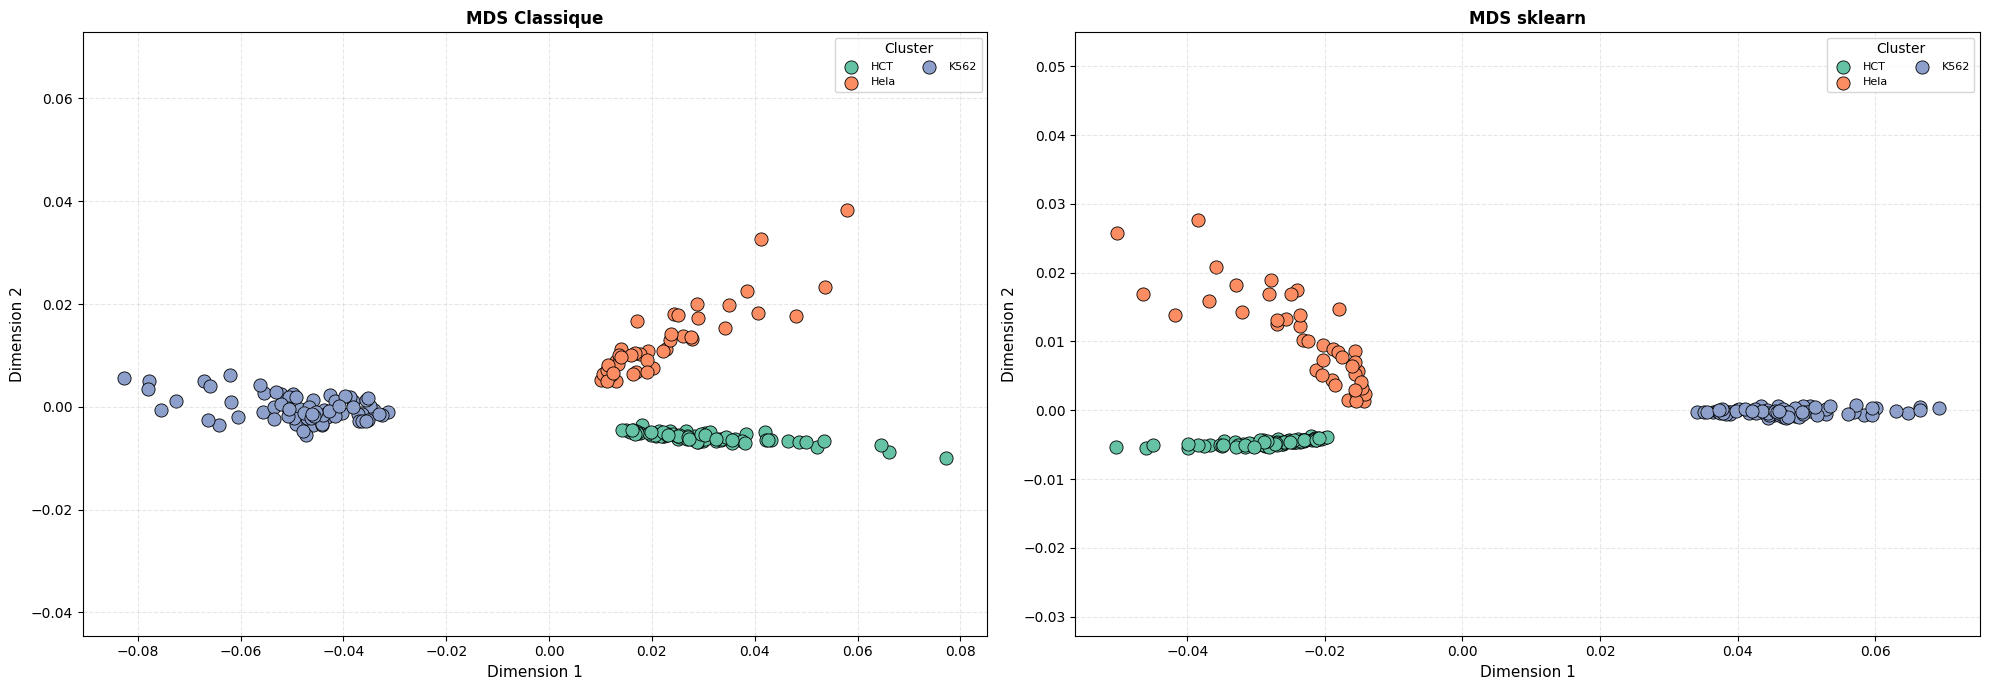

In [128]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder

# ============================================================
# PRÉPARATION DES DONNÉES
# ============================================================
labels_str = np.asarray(clusters).ravel()
le = LabelEncoder()
labels = le.fit_transform(labels_str)
n = D_ot.shape[0]

# ============================================================
# 1. MDS CLASSIQUE (Double centrage)
# ============================================================
# Algorithme classique
Delta = D_ot ** 2
H = np.eye(n) - np.ones((n, n)) / n
G = -0.5 * H @ Delta @ H

# Décomposition spectrale
eigvals, eigvecs = np.linalg.eigh(G)

# Trier par valeurs propres décroissantes
idx = np.argsort(eigvals)[::-1]
eigvals_sorted = eigvals[idx]
eigvecs_sorted = eigvecs[:, idx]

# Plongement 2D
Y_classical = eigvecs_sorted[:, :2] @ np.diag(np.sqrt(np.abs(eigvals_sorted[:2])))


# ============================================================
# 2. MDS SKLEARN (SMACOF)
# ============================================================
# MDS sklearn
mds = MDS(
    n_components=2,
    init="classical_mds", #random
    metric="precomputed",
    n_init=1,
    max_iter = 30000,
    random_state=42 
)

Y_sklearn = mds.fit_transform(D_ot)

# ============================================================
# 5. VISUALISATION COMPARATIVE
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
cmap = plt.cm.Set2

methods = [
    (Y_classical, f"MDS Classique", axes[0]),
    (Y_sklearn, f"MDS sklearn", axes[1]),
]

for Y, title, ax in methods:
    for i, label_name in enumerate(le.classes_):
        idx_lab = labels == i
        ax.scatter(
            Y[idx_lab, 0],
            Y[idx_lab, 1],
            color=cmap(i),
            s=90,
            alpha=1,
            edgecolors="black",
            linewidth=0.6,
            label=label_name
        )
    
    ax.set_xlabel("Dimension 1", fontsize=11)
    ax.set_ylabel("Dimension 2", fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.axis("equal")
    ax.grid(True, linestyle="--", alpha=0.3)
    
    # Afficher la légende sur TOUS les graphes
    ax.legend(title="Cluster", loc="best", frameon=True, fontsize=8, ncol=2)

plt.tight_layout()
plt.show()




In [129]:

import numpy as np
from scipy.sparse.csgraph import shortest_path
from scipy.linalg import eigh


def knn_graph_from_distance(D, k):
    """Build a symmetric kNN graph from a distance matrix."""
    n = D.shape[0]
    G = np.full((n, n), np.inf)

    for i in range(n):
        neighbors = np.argsort(D[i])[1:k+1]
        for j in neighbors:
            G[i, j] = D[i, j]
            #G[j, i] = D[i, j]

    np.fill_diagonal(G, 0)
    return G


import numpy as np
from sklearn.neighbors import NearestNeighbors

def knn_graph_from_distance_sklearn(D, k):
    """
    Build a kNN graph from a precomputed distance matrix using scikit-learn.
    The graph is directed (same behavior as standard kNN).
    """
    n = D.shape[0]
    G = np.full((n, n), np.inf)

    nbrs = NearestNeighbors(
        n_neighbors=k +1,     # +1 pour inclure le point lui-même
        metric="precomputed"
    )
    nbrs.fit(D)

    distances, indices = nbrs.kneighbors(D)

    for i in range(n):
        for idx in range(1, k + 1):  # on saute l'indice 0 (self)
            j = indices[i, idx]
            G[i, j] = distances[i, idx]

    np.fill_diagonal(G, 0)
    return G


def geodesic_distances(G):
    """Compute all-pairs geodesic distances."""
    D_geo = shortest_path(G, directed=False , method= 'D')
    return D_geo


def classical_mds(D, d=2):
    mds = MDS(
        n_components=d,
        init="classical_mds", #random
        metric="precomputed",
        n_init=1,
        max_iter=3,
        random_state=42,# empêche SMACOF de s’éloigner
        eps=0.0, 
    )
    
    Y_sklearn = mds.fit_transform(D)

    return Y_sklearn


def isomap_from_distance(D, k=10, n_components=2):
    """Isomap embedding from an OT distance matrix."""
    G = knn_graph_from_distance_sklearn(D, k)
    D_geo = geodesic_distances(G)
    X_iso = classical_mds(D_geo, n_components)
    return X_iso



In [130]:

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# ============================================================
# CALCUL DE L'ISOMAP
# ============================================================
# Encoder les labels
labels_str = np.asarray(clusters).ravel()
le = LabelEncoder()
labels = le.fit_transform(labels_str)

# Calculer l'embedding Isomap

k=74
X_iso = isomap_from_distance(D_ot, k=k, n_components=2)


Affichage de l'Isomap...


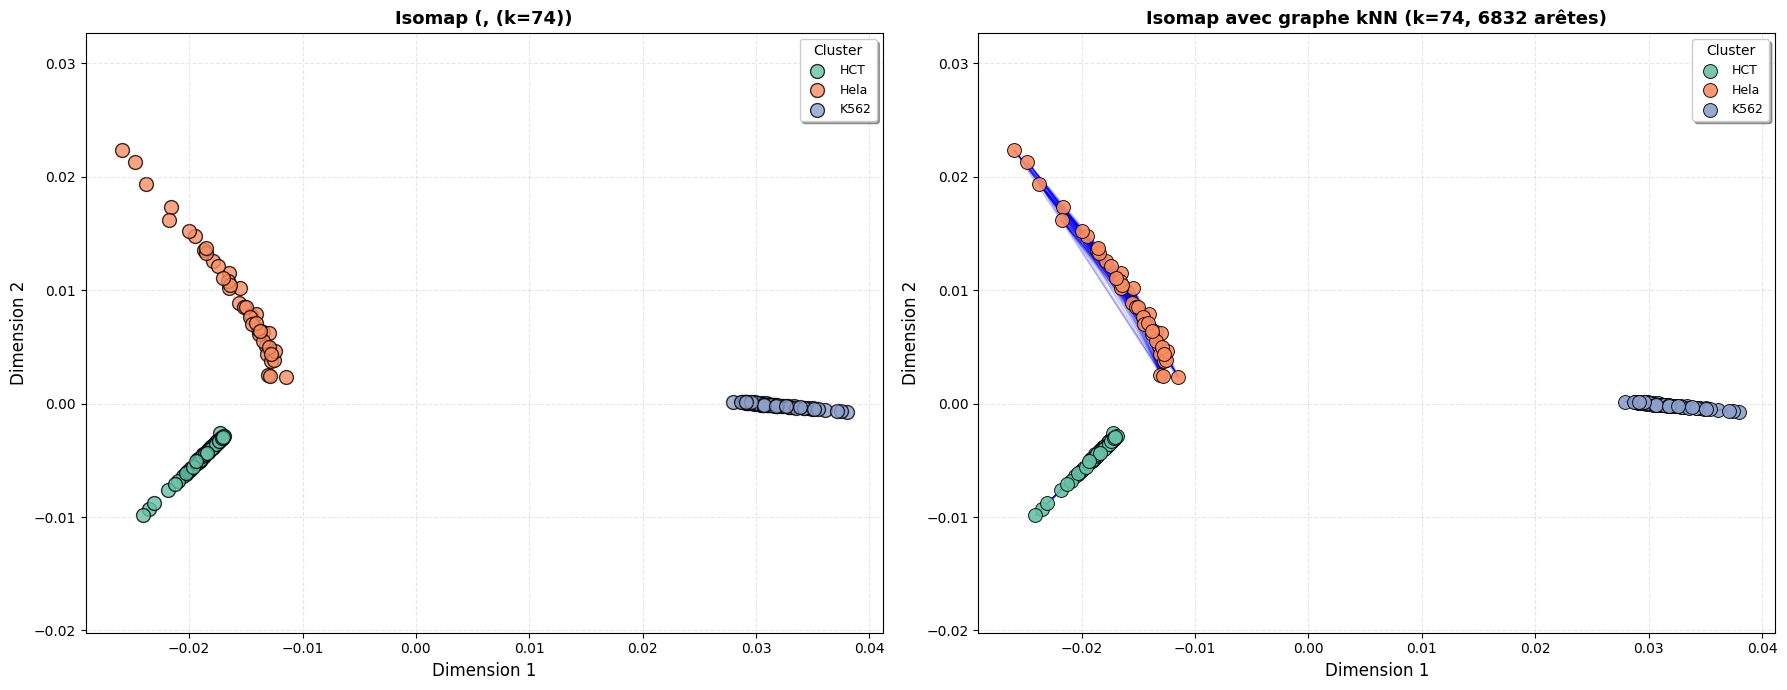

In [131]:

print("Affichage de l'Isomap...")
# ============================================================
# VISUALISATION
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
cmap = plt.cm.Set2

# ==================== SUBPLOT 1 : Points seulement ====================
ax1 = axes[0]

for i, label_name in enumerate(le.classes_):
    idx_lab = labels == i
    ax1.scatter(
        X_iso[idx_lab, 0],
        X_iso[idx_lab, 1],
        color=cmap(i),
        s=100,
        alpha=0.8,
        edgecolors="black",
        linewidth=1,
        label=label_name
    )

ax1.set_xlabel("Dimension 1", fontsize=12)
ax1.set_ylabel("Dimension 2", fontsize=12)
ax1.set_title(f"Isomap (, (k={k}))", fontsize=13, fontweight='bold')
ax1.axis("equal")
ax1.grid(True, linestyle="--", alpha=0.3)
ax1.legend(title="Cluster", loc="best", frameon=True, fontsize=9, fancybox=True, shadow=True)

# ==================== SUBPLOT 2 : Avec graphe kNN ====================
ax2 = axes[1]

# Reconstruire le graphe kNN pour visualisation
n = D_ot.shape[0]

# Trouver les voisins
knn_indices = []
knn_distances = []
for i in range(n):
    neighbors = np.argsort(D_ot[i])[1:k+1]
    knn_indices.append(neighbors)
    knn_distances.append(D_ot[i, neighbors])

# Dessiner les arêtes du graphe kNN
edge_count = 0
for i in range(n):
    for j_idx, j in enumerate(knn_indices[i]):
        if i < j:  # Éviter les doublons
            edge_count += 1
            # Couleur basée sur la distance
            dist = knn_distances[i][j_idx]
            color_intensity = min(dist / np.percentile(D_ot, 75), 1.0)
            edge_color = plt.cm.RdYlGn_r(color_intensity)
            
            ax2.plot(
                [X_iso[i, 0], X_iso[j, 0]],
                [X_iso[i, 1], X_iso[j, 1]],
                color="blue",
                alpha=0.3,
                linewidth=0.4,
                zorder=1
            )

# Dessiner les points
for i, label_name in enumerate(le.classes_):
    idx_lab = labels == i
    ax2.scatter(
        X_iso[idx_lab, 0],
        X_iso[idx_lab, 1],
        color=cmap(i),
        s=100,
        alpha=0.9,
        edgecolors="black",
        linewidth=0.7,
        label=label_name,
        zorder=3
    )

ax2.set_xlabel("Dimension 1", fontsize=12)
ax2.set_ylabel("Dimension 2", fontsize=12)
ax2.set_title(f"Isomap avec graphe kNN (k={k}, {edge_count} arêtes)", 
             fontsize=13, fontweight='bold')
ax2.axis("equal")
ax2.grid(True, linestyle="--", alpha=0.3)
ax2.legend(title="Cluster", loc="best", frameon=True, fontsize=9, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()



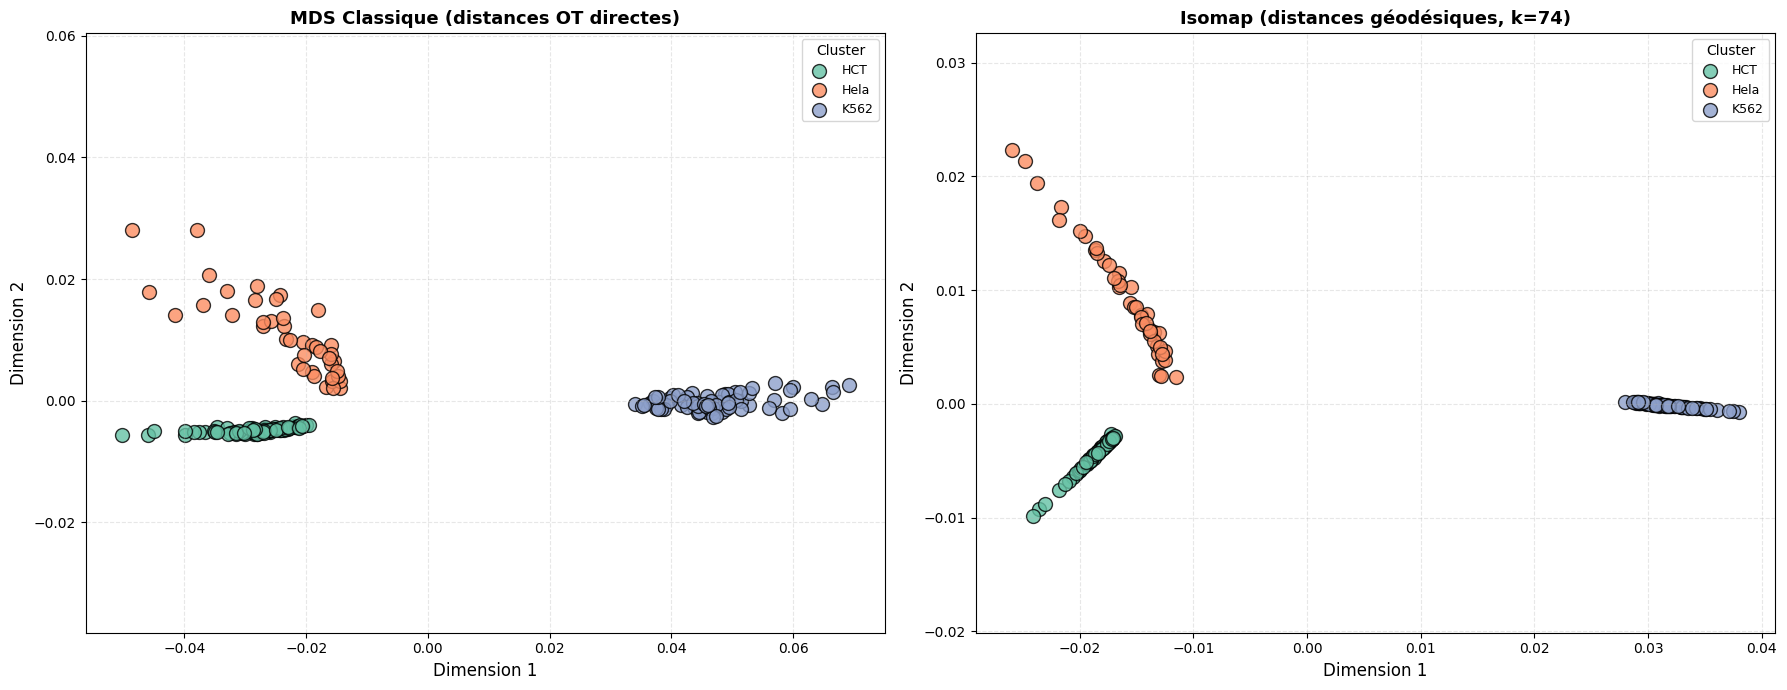

In [132]:

# COMPARAISON : MDS vs ISOMAP


# Visualisation comparative
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# MDS Classique
ax1 = axes[0]
for i, label_name in enumerate(le.classes_):
    idx_lab = labels == i
    ax1.scatter(
        classical_mds(D_ot,2)[idx_lab, 0],
        classical_mds(D_ot,2)[idx_lab, 1],
        color=cmap(i),
        s=100,
        alpha=0.8,
        edgecolors="black",
        linewidth=1,
        label=label_name
    )

ax1.set_xlabel("Dimension 1", fontsize=12)
ax1.set_ylabel("Dimension 2", fontsize=12)
ax1.set_title(f"MDS Classique (distances OT directes)", 
             fontsize=13, fontweight='bold')
ax1.axis("equal")
ax1.grid(True, linestyle="--", alpha=0.3)
ax1.legend(title="Cluster", loc="best", frameon=True, fontsize=9)

# Isomap
ax2 = axes[1]
for i, label_name in enumerate(le.classes_):
    idx_lab = labels == i
    ax2.scatter(
        X_iso[idx_lab, 0],
        X_iso[idx_lab, 1],
        color=cmap(i),
        s=100,
        alpha=0.8,
        edgecolors="black",
        linewidth=1,
        label=label_name
    )

ax2.set_xlabel("Dimension 1", fontsize=12)
ax2.set_ylabel("Dimension 2", fontsize=12)
ax2.set_title(f"Isomap (distances géodésiques, k={k})", 
             fontsize=13, fontweight='bold')
ax2.axis("equal")
ax2.grid(True, linestyle="--", alpha=0.3)
ax2.legend(title="Cluster", loc="best", frameon=True, fontsize=9)

plt.tight_layout()
plt.show()




In [133]:


#!pip install plotly
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"  # ou "colab" si tu es sur Colab
import numpy as np
from sklearn.manifold import MDS
from sklearn.neighbors import NearestNeighbors
from scipy.sparse.csgraph import shortest_path

# ============================================
# Paramètres
# ============================================
k_values = range(10, 200, 1)  # k de 80 à 89
stress_values = []

# ============================================
# Boucle sur chaque k
# ============================================
for k in k_values:
    n = D_ot.shape[0]
    
    # 1. Graphe kNN
    nbrs = NearestNeighbors(n_neighbors=k+1, metric="precomputed")
    nbrs.fit(D_ot)
    distances, indices = nbrs.kneighbors(D_ot)
    
    G = np.full((n, n), np.inf)
    for i in range(n):
        for idx in range(1, k+1):  # skip self
            j = indices[i, idx]
            G[i, j] = distances[i, idx]
    #G = np.minimum(G, G.T)  # symétriser le graphe
    np.fill_diagonal(G, 0)
    
    # 2. Distances géodésiques
    D_geo = shortest_path(G, directed=False, method='D')
    
    # Vérifier que toutes les distances sont finies
    if np.any(np.isinf(D_geo)):
        print(f"k={k}: graphe déconnecté, distances infinies")
        stress_values.append(np.nan)
        continue
    
    # 3. MDS sur distances géodésiques
    mds = MDS(
        n_components=2,
        init="classical_mds",
        metric='precomputed',
        random_state=42,
        max_iter=5000,
        n_init=1
    )
    Y = mds.fit_transform(D_geo)
    stress_values.append(mds.stress_)

# ============================================
# Tracé avec Plotly
# ============================================
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(k_values),
    y=stress_values,
    mode='lines+markers',
    line=dict(shape='spline', color='blue', width=2),
    marker=dict(size=4, color='blue'),
    name='Stress MDS'
))

fig.update_layout(
    title="Évolution du stress en fonction de k pour Isomap",
    xaxis_title="k (nombre de voisins)",
    yaxis_title="Stress de MDS",
    template="plotly_white",
    hovermode="x"
)

fig.show()

k=10: graphe déconnecté, distances infinies
k=11: graphe déconnecté, distances infinies
k=12: graphe déconnecté, distances infinies
k=13: graphe déconnecté, distances infinies
k=14: graphe déconnecté, distances infinies
k=15: graphe déconnecté, distances infinies
k=16: graphe déconnecté, distances infinies
k=17: graphe déconnecté, distances infinies
k=18: graphe déconnecté, distances infinies
k=19: graphe déconnecté, distances infinies
k=20: graphe déconnecté, distances infinies
k=21: graphe déconnecté, distances infinies
k=22: graphe déconnecté, distances infinies
k=23: graphe déconnecté, distances infinies
k=24: graphe déconnecté, distances infinies
k=25: graphe déconnecté, distances infinies
k=26: graphe déconnecté, distances infinies
k=27: graphe déconnecté, distances infinies
k=28: graphe déconnecté, distances infinies
k=29: graphe déconnecté, distances infinies
k=30: graphe déconnecté, distances infinies
k=31: graphe déconnecté, distances infinies
k=32: graphe déconnecté, distanc

# Avec la distance de Euclidienne

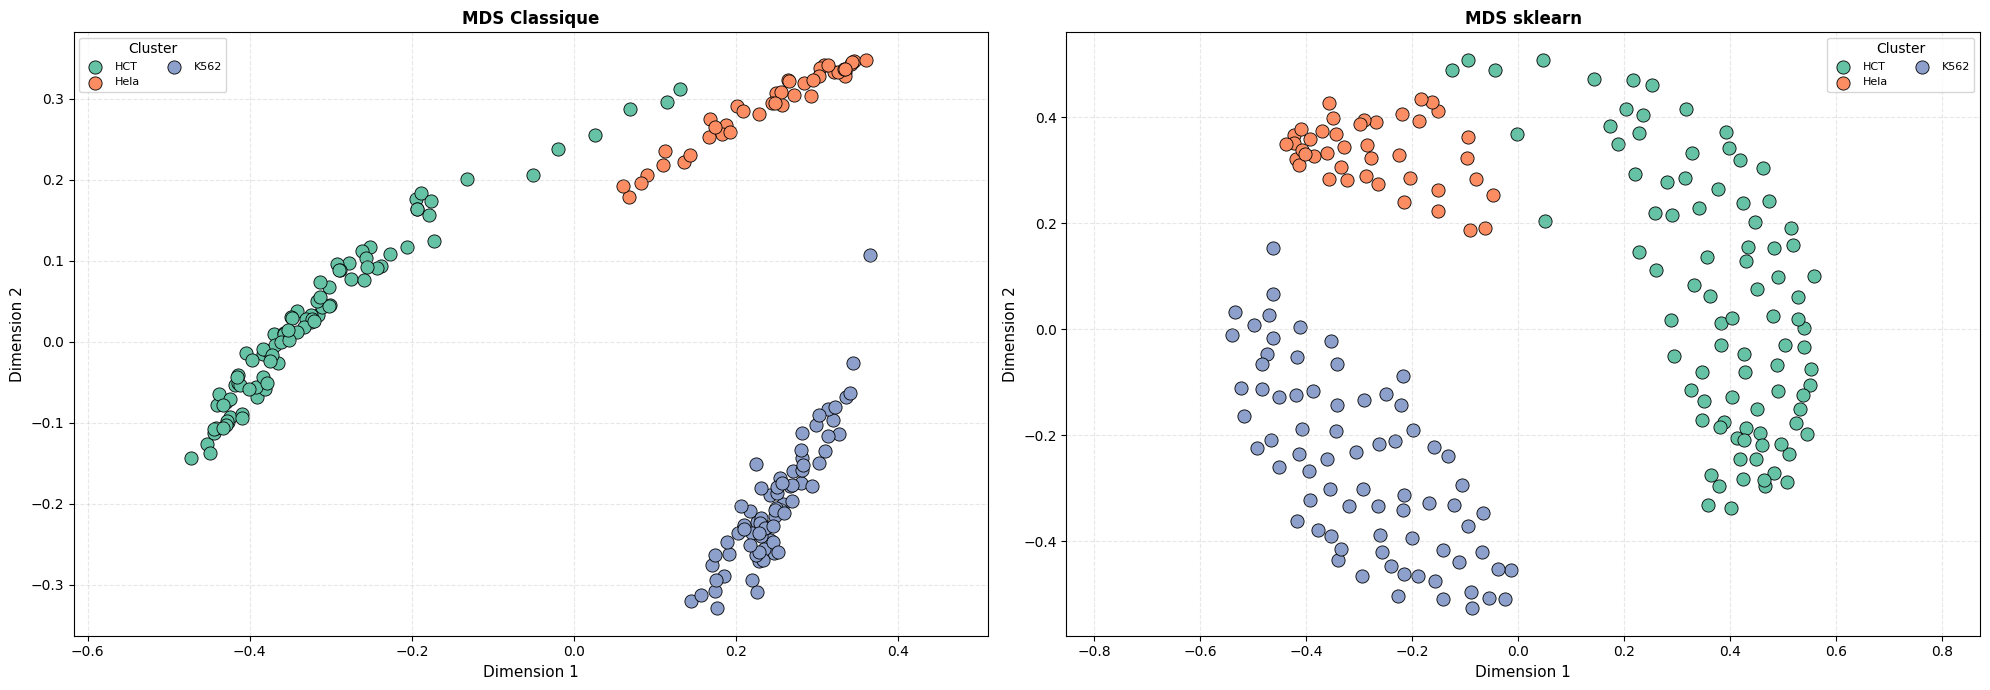

In [136]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder

# ============================================================
# PRÉPARATION DES DONNÉES
# ============================================================
labels_str = np.asarray(clusters).ravel()
le = LabelEncoder()
labels = le.fit_transform(labels_str)
n = D_ot.shape[0]

# ============================================================
# 1. MDS CLASSIQUE (Double centrage)
# ============================================================
# Algorithme classique
Delta = D_eu ** 2
H = np.eye(n) - np.ones((n, n)) / n
G = -0.5 * H @ Delta @ H

# Décomposition spectrale
eigvals, eigvecs = np.linalg.eigh(G)

# Trier par valeurs propres décroissantes
idx = np.argsort(eigvals)[::-1]
eigvals_sorted = eigvals[idx]
eigvecs_sorted = eigvecs[:, idx]

# Plongement 2D
Y_classical = eigvecs_sorted[:, :2] @ np.diag(np.sqrt(np.abs(eigvals_sorted[:2])))


# ============================================================
# 2. MDS SKLEARN (SMACOF)
# ============================================================
# MDS sklearn
mds = MDS(
    n_components=2,
    init="classical_mds", #random
    metric="precomputed",
    n_init=1,
    max_iter = 30000,
    random_state=42 
)

Y_sklearn = mds.fit_transform(D_eu)

# ============================================================
# 5. VISUALISATION COMPARATIVE
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
cmap = plt.cm.Set2

methods = [
    (Y_classical, f"MDS Classique", axes[0]),
    (Y_sklearn, f"MDS sklearn", axes[1]),
]

for Y, title, ax in methods:
    for i, label_name in enumerate(le.classes_):
        idx_lab = labels == i
        ax.scatter(
            Y[idx_lab, 0],
            Y[idx_lab, 1],
            color=cmap(i),
            s=90,
            alpha=1,
            edgecolors="black",
            linewidth=0.6,
            label=label_name
        )
    
    ax.set_xlabel("Dimension 1", fontsize=11)
    ax.set_ylabel("Dimension 2", fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.axis("equal")
    ax.grid(True, linestyle="--", alpha=0.3)
    
    # Afficher la légende sur TOUS les graphes
    ax.legend(title="Cluster", loc="best", frameon=True, fontsize=8, ncol=2)

plt.tight_layout()
plt.show()




In [137]:

D_geo = geodesic_distances(knn_graph_from_distance_sklearn(D_ot, 74))
print('Euclidean\t',  silhouette_score(D_eu, clusters, metric='precomputed'))
print('OT\t\t',       silhouette_score(D_ot, clusters, metric='precomputed'))
print('Geodesique\t ',silhouette_score(D_geo, clusters, metric='precomputed'))

Euclidean	 0.310142677550168
OT		 0.8380411531906459
Geodesique	  0.7994969025033293


In [138]:
print('Euclidean\t',  otscomics.C_index(D_eu, clusters))
print('OT\t\t',       otscomics.C_index(D_ot, clusters))
print('Geodesique\t',       otscomics.C_index(D_geo, clusters))


Euclidean	 0.034578119156775076
OT		 0.0023526581284776913
Geodesique	 0.003624333014180814


In [139]:
%cd /home/onyxia/work/OT-scOmics/docs/source/vignettes/
!pwd

/home/onyxia/work/OT-scOmics/docs/source/vignettes
/home/onyxia/work/OT-scOmics/docs/source/vignettes


# Gromov embeddings

In [89]:



import numpy as np
from scipy.spatial.distance import pdist, squareform, cosine
from sklearn.preprocessing import StandardScaler
from gw_mds import GromovWassersteinMultiDimensionalScaling


# ============================================================
# VOS DONNÉES (déjà normalisées)
# ============================================================

# Per-cell normalization (mandatory)
data_norm = adata.X.T.astype(np.double)  # Shape: (n_genes, n_cells)
data_norm /= data_norm.sum(0)
# Add a small value to avoid numerical errors
data_norm += 1e-9
data_norm /= data_norm.sum(0)

# Transposer pour avoir (n_cells, n_genes)
X = data_norm.T  # Shape: (n_cells, n_genes)

X_tensor = torch.from_numpy(X).float()

print("\n" + "="*60)
print("OPTION 1 : GW-MDS sur toutes les cellules")
print("="*60)

# Si vous avez trop de cellules, vous pouvez sous-échantillonner
n_cells = X.shape[0]

gw_mds = GromovWassersteinMultiDimensionalScaling(
    n_components=2,
    init='pca',
    optimizer_name='adam',
    learning_rate=0.1,
    metric_fn=None,
    precomputed_metric=False
)

print("\nAjustement de GW-MDS avec distance cosine...")
Y_gw_cosine = gw_mds.fit(X_tensor,n_iter=300)


Y_gw = gw_mds.embeddings_.clone().detach()



OPTION 1 : GW-MDS sur toutes les cellules

Ajustement de GW-MDS avec distance cosine...


[299] Loss: 0.0001414785801898688: 100%|██████████| 300/300 [12:52<00:00,  2.57s/it] 


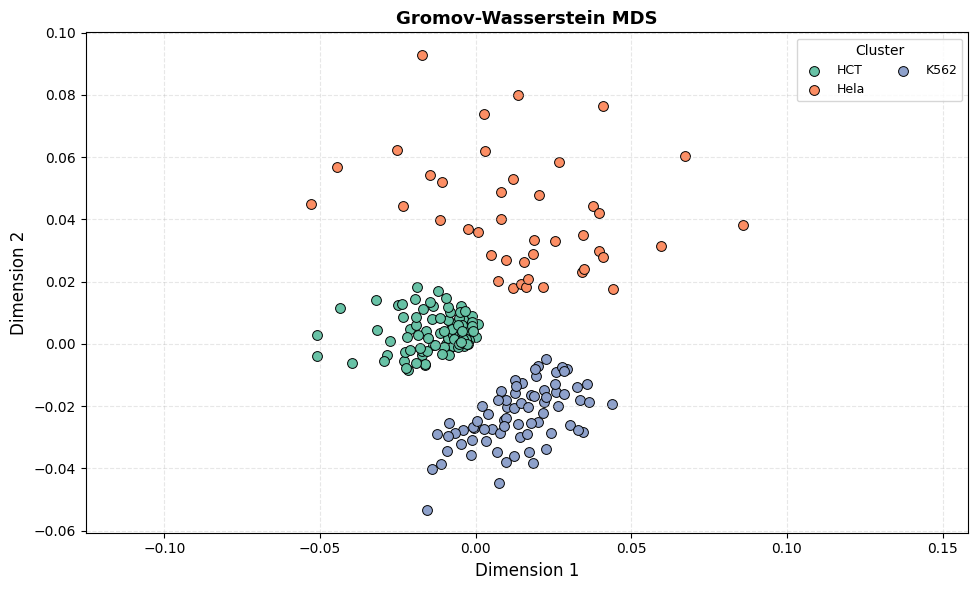

In [90]:

# ============================================
# 2. Visualisation comparative
# ============================================

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(clusters)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
cmap = plt.cm.Set2

for i, label_name in enumerate(le.classes_):
    idx_lab = labels == i
    ax.scatter(
        Y_gw[idx_lab, 0],
        Y_gw[idx_lab, 1],
        color=cmap(i),
        s=50,
        alpha=0.99,
        edgecolors="black",
        linewidth=0.7,
        label=label_name
    )

ax.set_xlabel("Dimension 1", fontsize=12)
ax.set_ylabel("Dimension 2", fontsize=12)
ax.set_title("Gromov-Wasserstein MDS", fontsize=13, fontweight='bold')
ax.axis("equal")
ax.grid(True, linestyle="--", alpha=0.3)
ax.legend(title="Cluster", loc="best", frameon=True, fontsize=9, ncol=2)

plt.tight_layout()
plt.show()


# EVALUATION DES METHODES

In [92]:
import numpy as np
from sklearn.metrics import (
    silhouette_score, 
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    adjusted_mutual_info_score
)
from sklearn.cluster import KMeans, DBSCAN
from scipy.stats import spearmanr, pearsonr
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import NearestNeighbors

# ============================================================
# FONCTION D'ÉVALUATION COMPLÈTE
# ============================================================

def evaluate_embedding(X_embedded, X_original, true_labels, method_name, n_clusters=None):
    """
    Évalue la qualité d'un embedding 2D
    
    Parameters:
    -----------
    X_embedded : array (n_samples, 2) - coordonnées 2D après réduction
    X_original : array ou matrice de distance (n_samples, n_features) ou (n_samples, n_samples)
    true_labels : array - labels vrais des clusters
    method_name : str - nom de la méthode
    n_clusters : int - nombre de clusters (si None, utilise len(np.unique(true_labels)))
    """
    
    if n_clusters is None:
        n_clusters = len(np.unique(true_labels))
    
    results = {'method': method_name}
    
    # ============================================================
    # 1. MÉTRIQUES INTRINSÈQUES (sans labels)
    # ============================================================
    
    # Clustering K-means sur l'embedding
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    predicted_labels = kmeans.fit_predict(X_embedded)
    
    # Silhouette
    results['silhouette_kmeans'] = silhouette_score(X_embedded, predicted_labels)
    results['silhouette_true'] = silhouette_score(X_embedded, true_labels)
    
    
    # ============================================================
    # 2. MÉTRIQUES EXTRINSÈQUES (avec labels)
    # ============================================================
    
    results['ARI'] = adjusted_rand_score(true_labels, predicted_labels)
    results['NMI'] = normalized_mutual_info_score(true_labels, predicted_labels)
    results['AMI'] = adjusted_mutual_info_score(true_labels, predicted_labels)
    
    # Purity
    contingency_matrix = np.zeros((n_clusters, n_clusters))
    for i in range(len(true_labels)):
        contingency_matrix[true_labels[i], predicted_labels[i]] += 1
    results['purity'] = np.sum(np.max(contingency_matrix, axis=1)) / len(true_labels)
    
    # ============================================================
    # 3. PRÉSERVATION DE LA STRUCTURE
    # ============================================================
    
    from scipy.spatial.distance import pdist, squareform
    # Si X_original est une matrice de distance
    if X_original.shape[0] == X_original.shape[1] and X_original.shape[0] == X_embedded.shape[0]:
        D_original = X_original
    else:
        from scipy.spatial.distance import pdist, squareform
        D_original = squareform(pdist(X_original))
    
    D_embedded = squareform(pdist(X_embedded))
    
    # Corrélation de Spearman entre distances
    upper_tri_idx = np.triu_indices_from(D_original, k=1)
    results['spearman_correlation'] = spearmanr(
        D_original[upper_tri_idx], 
        D_embedded[upper_tri_idx]
    )[0]
    
    
    return results


# ============================================================
# FONCTION POUR COMPARER TOUTES LES MÉTHODES
# ============================================================

def compare_all_methods(embeddings_dict, D_original, true_labels):
    """
    Compare plusieurs méthodes d'embedding
    
    Parameters:
    -----------
    embeddings_dict : dict - {method_name: X_embedded}
    D_original : array - matrice de distance originale
    true_labels : array - labels vrais
    """
    
    results_list = []
    
    for method_name, X_embedded in embeddings_dict.items():
        print(f"\n{'='*60}")
        print(f"Évaluation : {method_name}")
        print(f"{'='*60}")
        
        results = evaluate_embedding(
            X_embedded=X_embedded,
            X_original=D_original,
            true_labels=true_labels,
            method_name=method_name
        )
        
        results_list.append(results)
        
        # Affichage
        print(f"\n📊 MÉTRIQUES INTRINSÈQUES (clustering K-means)")
        print(f"  Silhouette (K-means)     : {results['silhouette_kmeans']:.4f}")
        print(f"  Silhouette (true labels) : {results['silhouette_true']:.4f}")
        
        print(f"\n🎯 MÉTRIQUES EXTRINSÈQUES (vs ground truth)")
        print(f"  ARI                      : {results['ARI']:.4f}")
        print(f"  NMI                      : {results['NMI']:.4f}")
        print(f"  AMI                      : {results['AMI']:.4f}")
        
        print(f"\n🔗 PRÉSERVATION DE LA STRUCTURE")
        print(f"  Spearman correlation     : {results['spearman_correlation']:.4f}")
    
    # Créer un DataFrame comparatif
    import pandas as pd
    df_results = pd.DataFrame(results_list)
    
    return df_results


# ============================================================
# EXEMPLE D'UTILISATION
# ============================================================

# Supposons que vous avez déjà calculé vos embeddings :
# - Y_gw : Gromov-Wasserstein MDS
# - Y_mds_classical : MDS classique
# - Y_mds_sklearn : MDS sklearn
# - X_iso : Isomap

embeddings = {
    'Gromov-Wasserstein MDS': Y_gw,
    'MDS Classique': Y_classical,
    'MDS Sklearn (SMACOF)': Y_sklearn,
    'Isomap (k=74)': X_iso
}

# Comparer toutes les méthodes
df_comparison = compare_all_methods(
    embeddings_dict=embeddings,
    D_original=D_ot,  # ou D_eu selon ce que vous voulez
    true_labels=labels  # labels encodés
)

# Afficher le tableau comparatif
print("\n" + "="*80)
print("TABLEAU COMPARATIF FINAL")
print("="*80)
df_comparison
# Sauvegarder en CSV
#df_comparison.to_csv('comparison_embeddings.csv', index=False)


Évaluation : Gromov-Wasserstein MDS

📊 MÉTRIQUES INTRINSÈQUES (clustering K-means)
  Silhouette (K-means)     : 0.5081
  Silhouette (true labels) : 0.5039

🎯 MÉTRIQUES EXTRINSÈQUES (vs ground truth)
  ARI                      : 0.9603
  NMI                      : 0.9443
  AMI                      : 0.9437

🔗 PRÉSERVATION DE LA STRUCTURE
  Spearman correlation     : 0.7248

Évaluation : MDS Classique

📊 MÉTRIQUES INTRINSÈQUES (clustering K-means)
  Silhouette (K-means)     : 0.7627
  Silhouette (true labels) : 0.7221

🎯 MÉTRIQUES EXTRINSÈQUES (vs ground truth)
  ARI                      : 0.9089
  NMI                      : 0.8853
  AMI                      : 0.8842

🔗 PRÉSERVATION DE LA STRUCTURE
  Spearman correlation     : 0.6641

Évaluation : MDS Sklearn (SMACOF)

📊 MÉTRIQUES INTRINSÈQUES (clustering K-means)
  Silhouette (K-means)     : 0.5686
  Silhouette (true labels) : 0.5300

🎯 MÉTRIQUES EXTRINSÈQUES (vs ground truth)
  ARI                      : 0.8139
  NMI                  

method  silhouette_kmeans  silhouette_true       ARI  \
0  Gromov-Wasserstein MDS           0.508105         0.503949  0.960323   
1           MDS Classique           0.762663         0.722140  0.908949   
2    MDS Sklearn (SMACOF)           0.568617         0.530000  0.813913   
3           Isomap (k=74)           0.823955         0.823955  1.000000   

        NMI       AMI    purity  spearman_correlation  
0  0.944267  0.943736  0.985437              0.724813  
1  0.885281  0.884208  0.966019              0.664094  
2  0.817298  0.815603  0.927184              0.686238  
3  1.000000  1.000000  1.000000              0.986294

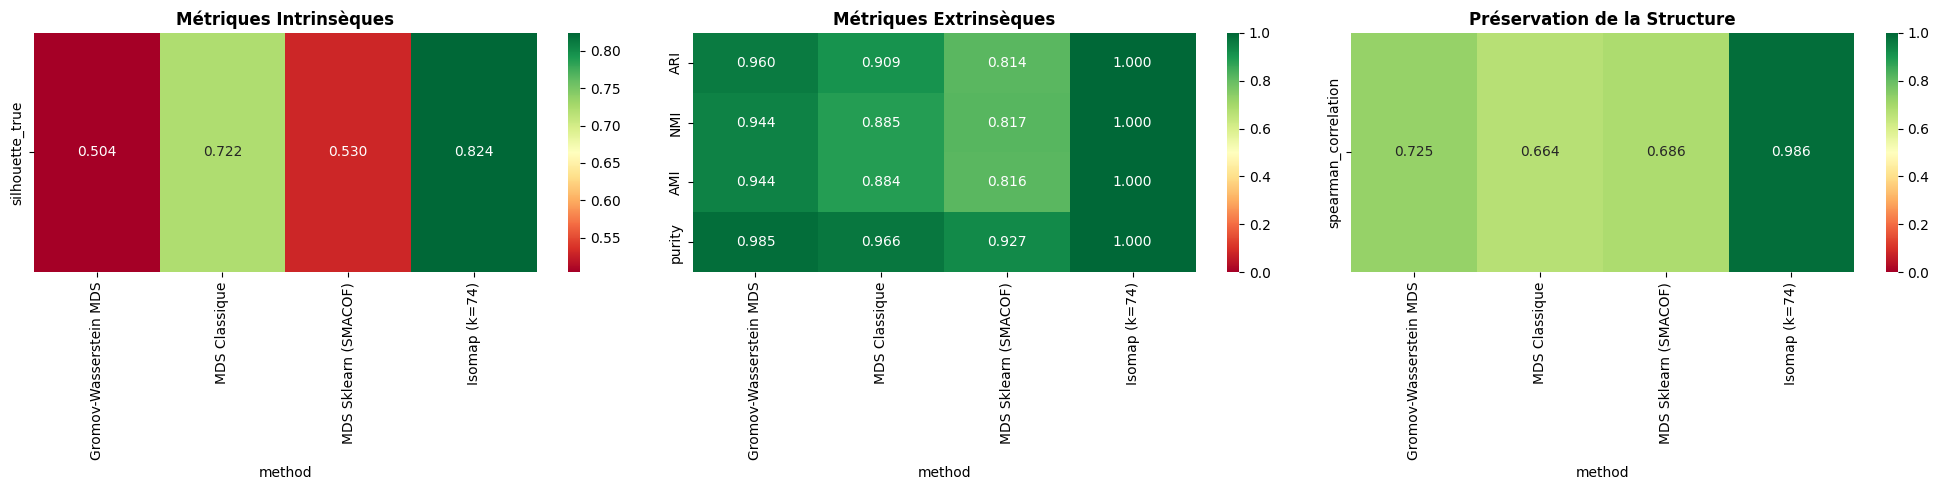

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# HEATMAP DES MÉTRIQUES
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Métriques intrinsèques
metrics_intrinsic = ['silhouette_true']
data_intrinsic = df_comparison[['method'] + metrics_intrinsic].set_index('method')

sns.heatmap(data_intrinsic.T, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[0])
axes[0].set_title('Métriques Intrinsèques', fontweight='bold')

# Métriques extrinsèques
metrics_extrinsic = ['ARI', 'NMI', 'AMI', 'purity']
data_extrinsic = df_comparison[['method'] + metrics_extrinsic].set_index('method')

sns.heatmap(data_extrinsic.T, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[1], vmin=0, vmax=1)
axes[1].set_title('Métriques Extrinsèques', fontweight='bold')

# Préservation structure
metrics_structure = ['spearman_correlation']
data_structure = df_comparison[['method'] + metrics_structure].set_index('method')

sns.heatmap(data_structure.T, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[2], vmin=0, vmax=1)
axes[2].set_title('Préservation de la Structure', fontweight='bold')

plt.tight_layout()
plt.show()